In [44]:
from netCDF4 import Dataset #Reading NetCDF files
import numpy as np
import xarray as xr
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import geocat.viz
ds = xr.open_dataset("/erai/1988/g.1988.nc",decode_times=False)

ModuleNotFoundError: No module named 'geocat.viz'

In [48]:
ds.g

<xarray.DataArray 'g' (time: 1464, lev: 37, lat: 256, lon: 512)>
[7099908096 values with dtype=float32]
Coordinates:
  * time     (time) float64 1.648e+06 1.648e+06 ... 1.657e+06 1.657e+06
  * lev      (lev) int32 1000 975 950 925 900 875 850 825 ... 30 20 10 7 5 3 2 1
  * lat      (lat) float32 -89.46282 -88.76695 -88.06697 ... 88.76695 89.46282
  * lon      (lon) float32 0.0 0.7 1.41 2.11 2.81 ... 357.19 357.89 358.59 359.3
Attributes:
    center:                   European Center for Medium-Range Weather Foreca...
    long_name:                Geopotential Height
    units:                    gpm
    level_indicator:          100
    gds_grid_type:            4
    parameter_table_version:  128
    parameter_number:         129
    forecast_time:            0
    forecast_time_units:      hours

In [21]:
##NCAR Code to eliminate cyclic longitudes, I suppose
def xr_add_cyclic_longitudes(da, coord):
    """
    Utility function to handle the no-shown-data artifact of 0 and 360-degree longitudes
    Args:
        da (:class:`xarray.core.dataarray.DataArray`):
            Data array that contains one or more coordinates, strictly including the coordinate with the name
            given with the "coord" parameter.
        coord (:class:`str`):
            Name of the longitude coordinate within "da" data array.
    """

    import xarray as xr
    import cartopy.util as cutil
    
    data = da["g"][:]
    
    cyclic_data, cyclic_coord = cutil.add_cyclic_point(data, coord=da[coord][:])

    coords = da.coords.to_dataset()
    coords[coord] = cyclic_coord

    new_da = xr.DataArray(cyclic_data,
                          dims=da.dims,
                          coords=coords.coords,
                          attrs=da.attrs)
    new_da.encoding = da.encoding

    return new_da

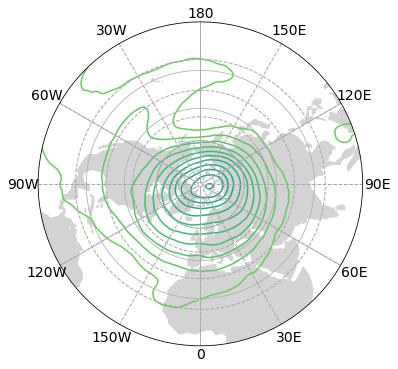

In [60]:
fig = plt.figure(figsize=[10, 5])
ax = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
fig.subplots_adjust(bottom=0.05, top=0.95,
                    left=0.04, right=0.95, wspace=0.02)

# Limit the map to 40 degrees latitude and below.
ax.set_extent([-180, 180, 0, 40], ccrs.PlateCarree())

ax.add_feature(cfeature.LAND,facecolor='lightgray')


ax.gridlines()


# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

#from NCl, messing with grid lines to produce manipulated longitudes and latitudes
gl = ax.gridlines(ccrs.PlateCarree(),
                  draw_labels=False,
                  linestyle="--",
                  linewidth=1,
                  color='darkgray',
                  zorder=2)
gl.ylocator = mticker.FixedLocator(np.arange(0, 90, 15))
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))

ticks = np.arange(0, 210, 30)
etick = ['0'] + [
    r'%dE' % tick for tick in ticks if (tick != 0) & (tick != 180)
] + ['180']
wtick = [r'%dW' % tick for tick in ticks if (tick != 0) & (tick != 180)]
labels = etick + wtick
xticks = np.arange(0, 360, 30)
yticks = np.full_like(xticks, -5)  # Latitude where the labels will be drawn
for xtick, ytick, label in zip(xticks, yticks, labels):
    if label == '180':
        ax.text(xtick,
                ytick,
                label,
                fontsize=14,
                horizontalalignment='center',
                verticalalignment='top',
                transform=ccrs.Geodetic())
    elif label == '0':
        ax.text(xtick,
                ytick,
                label,
                fontsize=14,
                horizontalalignment='center',
                verticalalignment='bottom',
                transform=ccrs.Geodetic())
    else:
        ax.text(xtick,
                ytick,
                label,
                fontsize=14,
                horizontalalignment='center',
                verticalalignment='center',
                transform=ccrs.Geodetic())

#####################################
#now, begin plotting data
#start with the 0th time step

p = ds.isel(time=0,lev=31).g
lat = ds.lat
lon = ds.lon

ax.contour(lon,lat,p,np.arange(24000,33000,200),levels = 55000, transform=ccrs.PlateCarree())
